# 1. Reading data (5%)

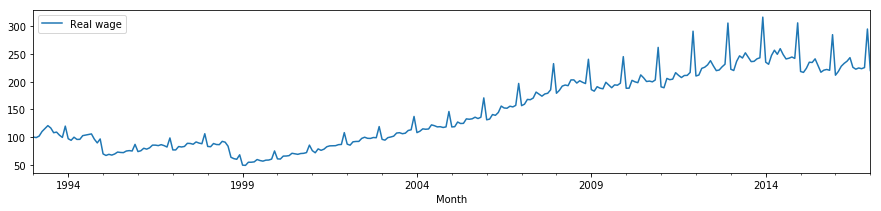

In [113]:
import pandas as pd
import numpy as np
from utils import qualityRMSE, qualityMedianAE
from utils import ExponentialSmoothing
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

df1 = pd.read_csv('monthly-wage.csv', sep=';', decimal='.', index_col='Month', parse_dates=True, dayfirst=True)
df1.plot(figsize=(15,3))

There is a trend, since the values tend to grow over time. There is a seasonality, since the shape remains more or less the same, on the other hand, the level changes. 

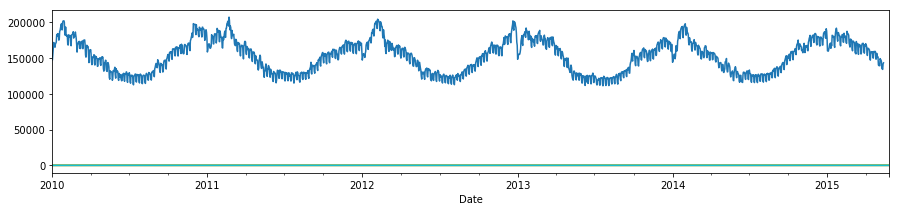

In [109]:
df2 = pd.read_csv('energy_consump.csv', sep=',', decimal='.', index_col='Date', parse_dates=True, dayfirst=True)
df2.plot(figsize=(15,3), legend=None)

There is seasonality but overall no trend and no level changes.


# 2. ARIMA Model for wage dataset (40%)

# I. Select ARIMA parameters your self Also you can follow the next scheme:

In [121]:
def qualityMACAPE(x,y):
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

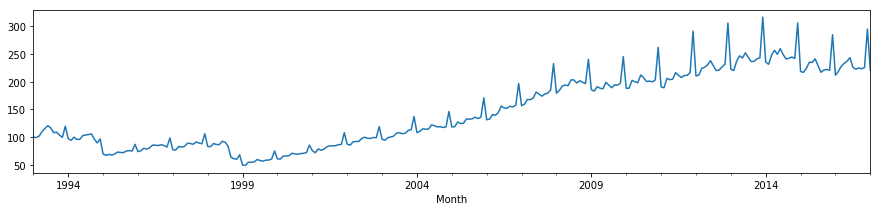

In [114]:
df1_cut = df1['1999-01-01':'2015-02-01'] #triming the tail
df1_cut = df1[df1.columns[0]].dropna()
df1_cut.plot(figsize=(15,3))

Clearly, the TS is not stationary, so we need to apply differencing.

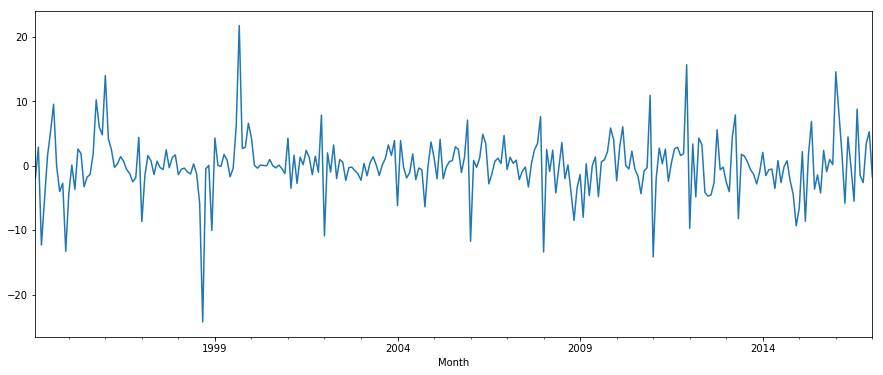

In [116]:
# seasonal differencing
p = 12
sdiff_df1 = (df1_cut - df1_cut.shift(p))[p:]

diff_df1 = (sdiff_df1  - sdiff_df1.shift(1))[1:]
diff_df1.plot(figsize=(15,6))

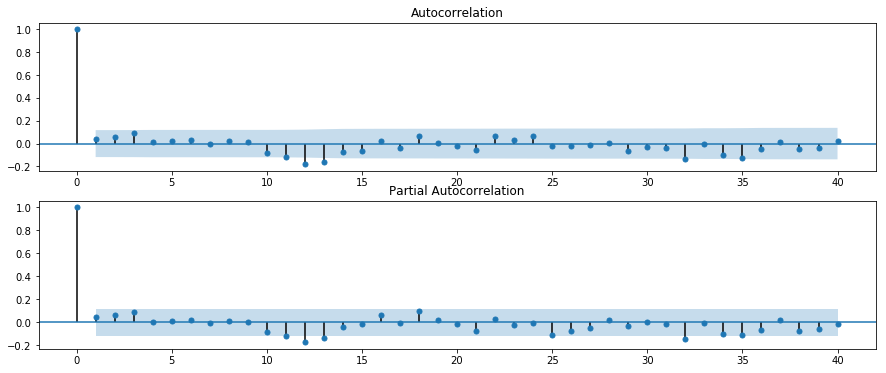

In [117]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_df1.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_df1, lags=40, ax=ax2)

In [220]:
p=0
d=1
q=1
s=12
P=3
D=1
Q=1 


mod = sm.tsa.statespace.SARIMAX(diff_df1, trend='c', order=(p,d,q), seasonal_order=(P,D,Q,s)).fit()
print ("aic = {aic}, bic = {bic}".format(aic=mod.aic, bic=mod.bic))

C:\Users\Shahane\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic = 1593.6250829078854, bic = 1618.9678889679053


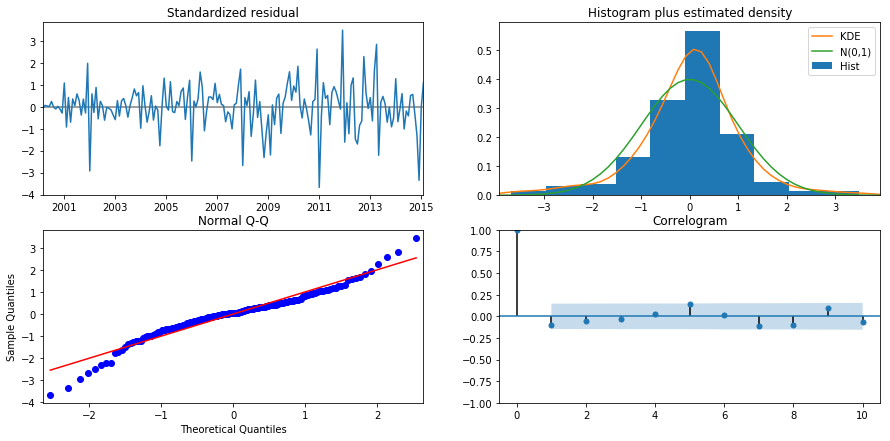

In [69]:
mod = sm.tsa.statespace.SARIMAX(diff_df1, trend='c', order=(0,1,1), seasonal_order=(4,0,1,12)).fit()
mod.plot_diagnostics(figsize=(15, 7))
plt.show()

In [219]:
mod1 = sm.tsa.statespace.SARIMAX(df1[:'2015-02-01'], order=(1,0,1), seasonal_order=(3,1,1,12)).fit()

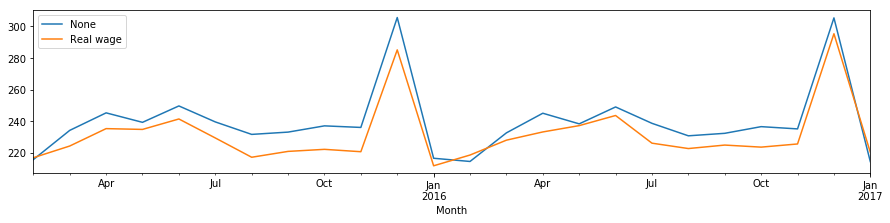

In [120]:
predict=mod1.predict(start='2015-02-01', end='2017-01-01')
predict.plot(figsize=(15,3))
df1["Real wage"]['2015-02-01':].plot()
plt.legend()

I guess the forcast looks like appropriate)) 

In [122]:
acc = 1-qualityMACAPE(predict,df1['Real wage']['2015-02-01':])[0]
print(acc)

0.9615646690734904


# II. Find the best parameters of ARIMA automaticaly

In [230]:
def ParamSearch(p,d,q,P,D,Q,s,df):
    aic_value = []
    params = [0]*6
    all_params = []
    start=time.time()
    for pi in p:
        for di in d:
            for qi in q:
                for Pi in P:
                    for Di in D:
                        for Qi in Q:

                            try:
                                mod = sm.tsa.statespace.SARIMAX(df[:'2015-02-01'], trend='n', order=(pi,di,qi), seasonal_order=(Pi,Di,Qi,12)).fit()
                                params[0] = pi
                                params[1] = di
                                params[2] = qi
                                params[3] = Pi
                                params[4] = Di
                                params[5] = Qi
                                aic_value.append(mod.aic)
                                all_params.append(params)
                                break
                            except Exception:
                                pass

    print("\nThe selected parameters are p,d,q,P,D,Q = "+str(all_params[np.argmin(np.array(aic_value))])+"; AIC: "+str(min(aic_value)))
    print("\nTime taken: "+str((time.time()-start)/60.0)+" min")                      
#I know I could have created a grid with lists of parameters, 
#I actually did that but there was some bug and I wasn't able to find it for hours..    
p=[0,1]
d=[0,1]
q=[1,1]
s=12
P=[1,2,3]
D=[0,1]
Q=[0,1]
ParamSearch(p,d,q,P,D,Q,s,df1)


The selected parameters are p,d,q,P,D,Q = [1, 0, 1, 3, 1, 0]; AIC: 1473.95335114

Time taken: 0.29426682790120445 min


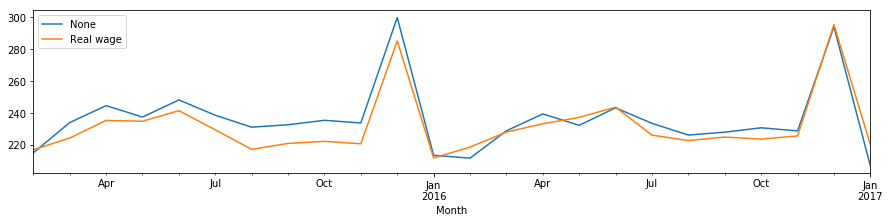

In [228]:
mod = sm.tsa.statespace.SARIMAX(df1[:'2015-02-01'], order=(1,0,1), seasonal_order=(3,1,0,12)).fit()
predict=mod.predict(start='2015-02-01', end='2017-01-01')
predict.plot(figsize=(15,3))
df1["Real wage"]['2015-02-01':'2017-01-01'].plot()
plt.legend()

In [229]:
acc = 1-qualityMACAPE(predict,df1['Real wage']['2015-02-01':])[0]
print(acc)

0.9703640661414623


# 3. ARIMA Model for wage dataset (55%)

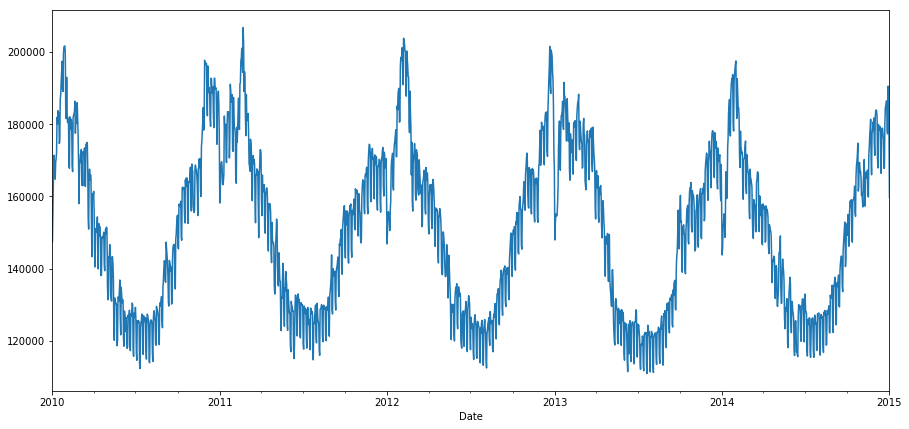

In [231]:
df2=df2[:"2015-01-01"]
df2['EnergyConsump'].plot(figsize=(15,7))
plt.show()

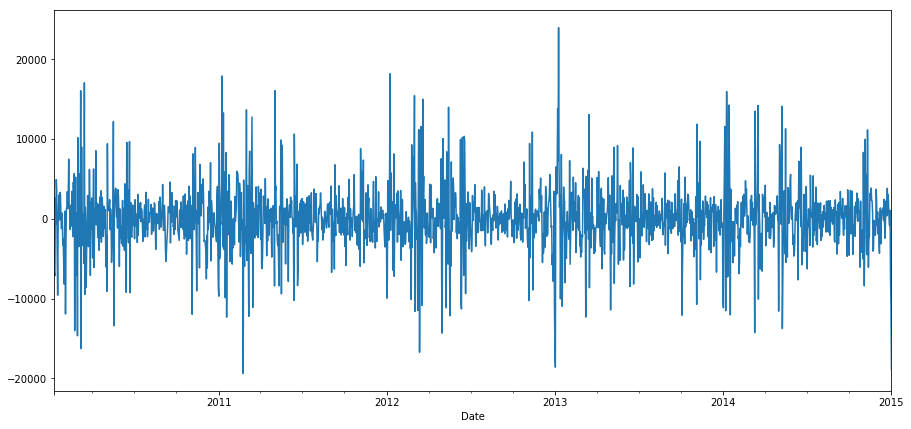

In [232]:
# seasonal differencing
p = 7
sdiff_df2 = (df2['EnergyConsump'] - df2['EnergyConsump'].shift(p))[p:]
diff_df2 = (sdiff_df2  - sdiff_df2.shift(1))[1:]
diff_df2.plot(figsize=(15,7))
plt.show()

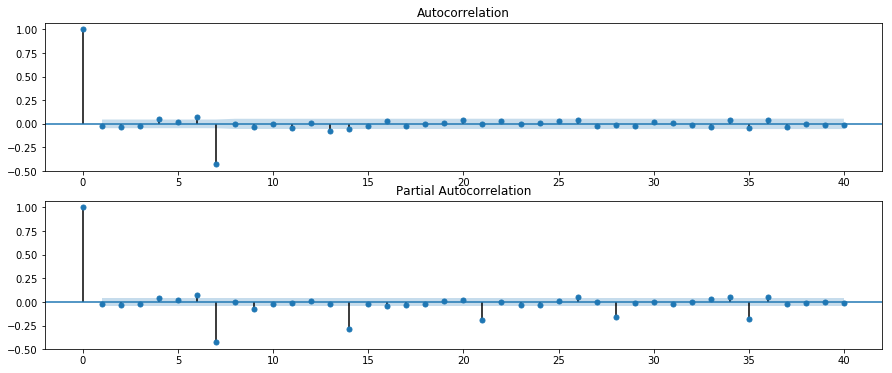

In [233]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_df2.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_df2, lags=40, ax=ax2)

In [234]:
p=1 
d=1 
q=0

s=7

P=5
D=0 
Q=2

mod = sm.tsa.statespace.SARIMAX(diff_df2, trend='n', order=(p,d,q), seasonal_order=(P,D,Q,s)).fit()
print(mod.aic)

35403.366906054245

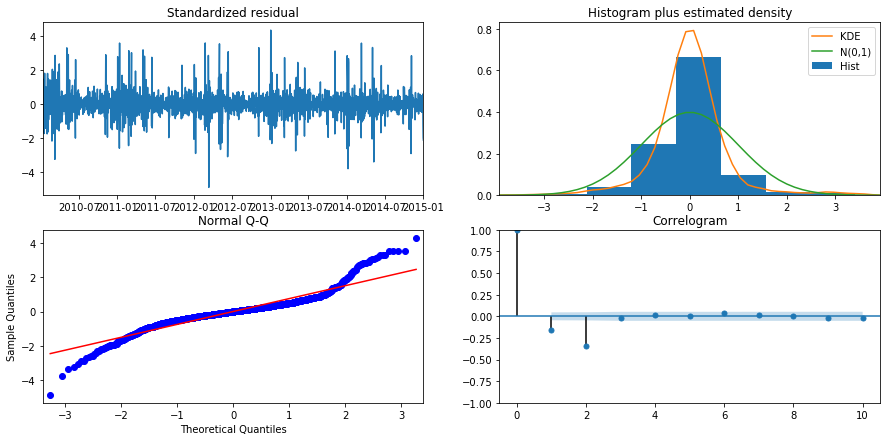

In [235]:
mod.plot_diagnostics(figsize=(15, 7))
plt.show()

In [260]:
p=1 
d=1 
q=0

s=7

P=9
D=1 
Q=1
mod2 = sm.tsa.statespace.SARIMAX(df2['EnergyConsump'][:'2014-08-28'], order=(p,d,q), seasonal_order=(P,D,Q,s)).fit()
print(mod2.aic)

32468.5707309


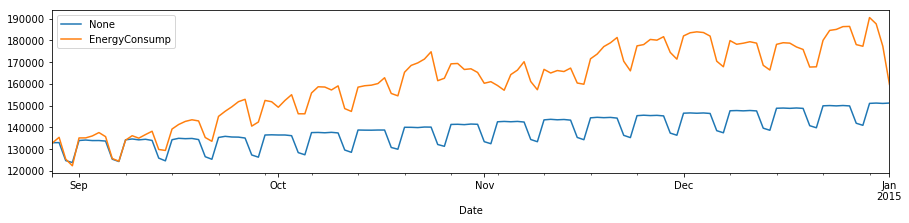

In [264]:
predict=mod2.predict(start='2014-08-28', end='2015-01-01')
predict.plot(figsize=(15,3))
df2['EnergyConsump']['2014-08-28':'2015-01-01'].plot()
plt.legend()

In [265]:
acc = 1-qualityMACAPE(predict,df2['EnergyConsump']['2014-08-28':'2015-01-01'])[0]
print(acc)

0.8579085903933374


In [267]:
df3 = df2[['Temp1', 'Temp2', 'Saturday','Sunday']]

p=1
d=1
q=0
s=7 
P=9 
D=1 
Q=1

mod = sm.tsa.statespace.SARIMAX(df2['EnergyConsump'][:'2014-08-28'], exog=df3[:'2014-08-28'], order=(p,d,q), seasonal_order=(P,D,Q,s)).fit()
print(mod.aic)

31405.0459163


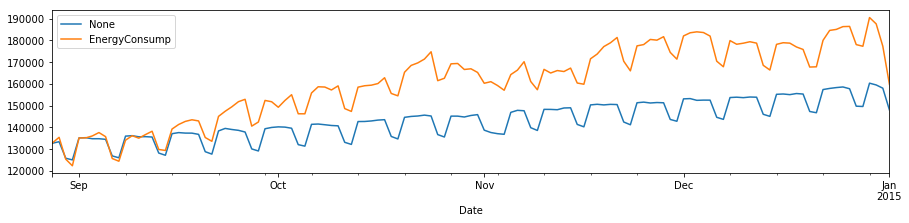

In [270]:
predict=mod.predict(start='2014-08-28', end='2015-01-01', exog=df3['2014-08-29':'2015-01-01'])
predict.plot(figsize=(15,3))
df2['EnergyConsump']['2014-08-28':'2015-01-01'].plot()
plt.legend()

In [271]:
acc = 1-qualityMACAPE(predict,df2['EnergyConsump']['2014-08-28':'2015-01-01'])[0]
print(acc)

0.8872758672244654


In [275]:
p=1 
d=1 
q=0

s=7

P=9
D=1 
Q=1
mod2 = sm.tsa.statespace.SARIMAX(df2['EnergyConsump'][:'2015-02-01'], order=(p,d,q), seasonal_order=(P,D,Q,s)).fit()
print(mod2.aic)

35500.1270905


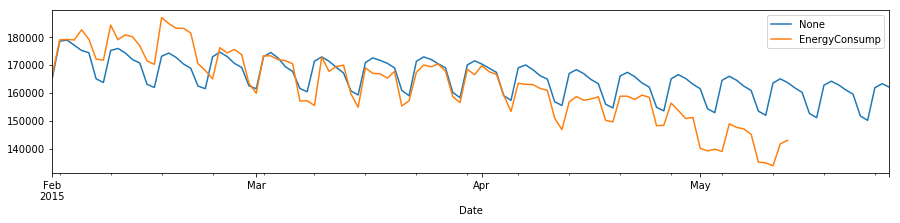

In [283]:
predict=mod2.predict(start='2015-02-01', end='2015-05-27')
predict.plot(figsize=(15,3))
df2['EnergyConsump']['2015-02-01':'2015-05-27'].plot()
plt.legend()

In [284]:
acc = 1-qualityMACAPE(predict,df2['EnergyConsump']['2015-02-01':'2015-05-27'])[0]
print(acc)

0.9566255615016898


In [285]:
df3 = df2[['Temp1', 'Temp2', 'Saturday','Sunday']]

p=1
d=1
q=0
s=7 
P=9 
D=1 
Q=1

mod = sm.tsa.statespace.SARIMAX(df2['EnergyConsump'][:'2015-02-01'], exog=df3[:'2015-02-01'], order=(p,d,q), seasonal_order=(P,D,Q,s)).fit()
print(mod.aic)

34327.7721144


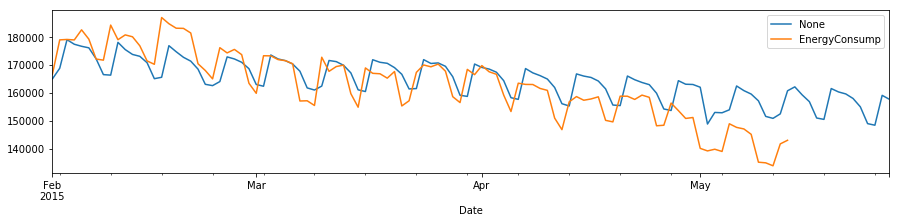

In [296]:
predict=mod.predict(start='2015-02-01', end='2015-05-27', exog=df3['2015-02-01':'2015-05-26'])
predict.plot(figsize=(15,3))
df2['EnergyConsump']['2015-02-01':'2015-05-27'].plot()
plt.legend()

In [297]:
acc = 1-qualityMACAPE(predict,df2['EnergyConsump']['2015-02-01':'2015-05-27'])[0]
print(acc)

0.9584270084230033


I tried forcasting '2014-08-28':'2015-01-01' and '2015-02-01':'2015-05-27'. In the first case the accuracies when using extra variables was much better, while in the second case the accuracies were nearly the same.